In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alyahmedts13/reddit-sentiment-analysis-dataset-for-nlp-projects")

print("Path to dataset files:", path)

100%|██████████| 1.15M/1.15M [00:00<00:00, 79.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/alyahmedts13/reddit-sentiment-analysis-dataset-for-nlp-projects/versions/1


In [10]:
!ls /root/.cache/kagglehub/datasets/alyahmedts13/reddit-sentiment-analysis-dataset-for-nlp-projects/versions/1



reddit_artist_posts_sentiment.csv


In [11]:
import pandas as pd
df = pd.read_csv("/root/.cache/kagglehub/datasets/alyahmedts13/reddit-sentiment-analysis-dataset-for-nlp-projects/versions/1/reddit_artist_posts_sentiment.csv")
df.head()

,text,label
0,pitchfork track review: taylor swift’s “actual...,negative
1,taylor swift has regained the masters of her f...,positive
2,pitchfork review: taylor swift - the life of a...,neutral
3,taylor swift announced engagement,neutral
4,taylor swift - the fate of ophelia (official m...,neutral


--- INFORME DE CLASIFICACIÓN ---
              precision    recall  f1-score   support

    negative       0.50      0.64      0.56       679
     neutral       0.84      0.75      0.80      3946
    positive       0.66      0.74      0.70      1765

    accuracy                           0.74      6390
   macro avg       0.67      0.71      0.69      6390
weighted avg       0.76      0.74      0.74      6390



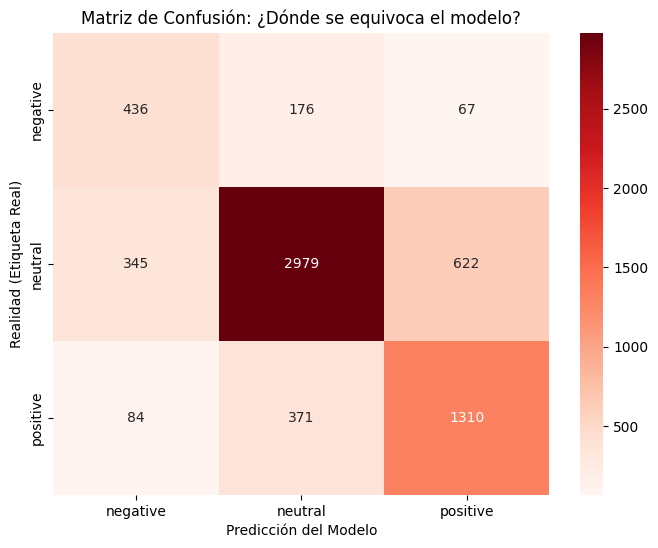

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# 1. Limpieza rápida de los datos (quitar nulos si existen)
amazon_reviews = df.dropna(subset=['text', 'label'])

# 2. Dividir en conjuntos de Entrenamiento y Prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    amazon_reviews['text'],
    amazon_reviews['label'],
    test_size=0.20,
    random_state=42,
    stratify=amazon_reviews['label'] # Mantiene la proporción de sentimientos en ambos grupos
)

# 3. Crear el Pipeline
# Usamos class_weight='balanced' para que el modelo le dé más importancia a los "Negative"
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2))),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
])

# 4. Entrenar el modelo
text_clf.fit(X_train, y_train)

# 5. Hacer predicciones
predictions = text_clf.predict(X_test)

# --- EVALUACIÓN DEL MODELO ---

print("--- INFORME DE CLASIFICACIÓN ---")
print(classification_report(y_test, predictions))

# 6. Matriz de Confusión para ver dónde falla
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, predictions, labels=['negative', 'neutral', 'positive'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Realidad (Etiqueta Real)')
plt.title('Matriz de Confusión: ¿Dónde se equivoca el modelo?')
plt.show()

#Interpretación:

1. Análisis del Informe:

* La clase "Negativa" (El reto principal):
Recall (0.64): El modelo es capaz de encontrar el 64% de todos los comentarios negativos que existen.
Precision (0.50):De cada 10 comentarios que el modelo marca como "negativos", solo 5 lo son realmente. La otra mitad son probablemente comentarios "neutrales" que el modelo confundió con negativos.
F1-Score (0.56): Es el promedio de los dos anteriores. Nos dice que el modelo todavía sufre para distinguir el odio o la crítica de la información neutral.
La clase "Neutral" (La más fuerte):
Precision (0.84): Es muy alta. Si el modelo dice que algo es neutral, tiene un 84% de probabilidad de tener razón. Esto es porque tienes muchos datos de esta clase.
La clase "Positiva":
F1-Score (0.70): El modelo es bastante bueno detectando sentimientos positivos.

In [14]:
from sklearn.ensemble import RandomForestClassifier

text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2))),
    ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])

In [15]:
# Crear un DataFrame con los resultados de prueba
resultados = pd.DataFrame({'Texto': X_test, 'Real': y_test, 'Prediccion': predictions})

# Ver ejemplos donde el modelo dijo "negativo" pero era "neutral"
errores_negativos = resultados[(resultados['Real'] == 'neutral') & (resultados['Prediccion'] == 'negative')]

print("Ejemplos de falsos negativos (el modelo se confundió):")
print(errores_negativos['Texto'].head(5).values)

Ejemplos de falsos negativos (el modelo se confundió):
['bad guy by billie eilish except she says the word "dad" 86 times [oc]'
 "it's hard to watch ringo's face and not laugh."
 'presale codes for barcelona please im desperate'
 'the strings section in pop music part 2 (spanish)'
 'question about hmhas tour i have tickets to a concert and i obviously want to wear  billie merch to the concert, but i only have a hte hoodie, would that be ok? ik she plays some of the hte songs but i just want to make sure.']


#Interpretación:

El problema de los títulos:
'bad guy by billie eilish...'

* 1: El modelo ve la palabra "bad" y automáticamente piensa que es un post negativo. No entiende que "Bad Guy" es el nombre de una canción.
El problema del lenguaje figurado: "it's hard to watch ringo's face and not laugh."
* 2:La frase "hard to watch" suele usarse para cosas horribles o violentas (negativo), pero aquí se usa para decir que algo es muy gracioso. El modelo no entiende la ironía o el contexto humorístico.
Palabras de "intensidad" emocional: '...please im desperate'
* 3: La palabra "desperate" (desesperado) tiene una carga negativa muy fuerte en los diccionarios de sentimiento, aunque aquí sea solo un fan emocionado buscando entradas.
Ambigüedad en textos largos: El post sobre el hoodie de Billie Eilis
* 4: Contiene palabras como "question", "merch", "but" y "just". Al ser un texto largo y con dudas, el modelo se confunde ante la falta de palabras claramente positivas.


In [1]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

In [8]:
# 1. Descargas necesarias de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [9]:
# 2. Configuración de Stopwords y Lematizador
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [10]:
import pandas as pd
# --- PERSONALIZACIÓN ---
# Añadimos palabras que causan ruido en este contexto artístico
palabras_ruido = {'guy', 'face', 'watch', 'sure', 'would'}
stop_words.update(palabras_ruido)

# Función de limpieza y lematización
def preprocesar_avanzado(texto):
    # a. Limpieza básica (minúsculas y quitar caracteres especiales/links)
    texto = texto.lower()
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto)
    texto = re.sub(r'[^a-z\s]', '', texto)

    # b. Tokenización (separar en palabras)
    tokens = word_tokenize(texto)

    # c. Lematización y quitar Stopwords
    tokens_limpios = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words and len(word) > 2
    ]

    return " ".join(tokens_limpios)

# Ensure 'df' is defined. This line is added to handle the NameError.
df = pd.read_csv("/root/.cache/kagglehub/datasets/alyahmedts13/reddit-sentiment-analysis-dataset-for-nlp-projects/versions/1/reddit_artist_posts_sentiment.csv")

# 3. Aplicar el preprocesamiento al dataset
print("Procesando textos... esto puede tardar unos segundos.")
# Define amazon_reviews, assuming 'df' is available from a previous cell
amazon_reviews = df.dropna(subset=['text', 'label'])
amazon_reviews['text_final'] = amazon_reviews['text'].apply(preprocesar_avanzado)

# 4. Entrenar el nuevo modelo con los textos lematizados
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    amazon_reviews['text_final'],
    amazon_reviews['label'],
    test_size=0.20,
    random_state=42,
    stratify=amazon_reviews['label']
)

# Usamos un Pipeline más robusto
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000)),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
])

text_clf.fit(X_train, y_train)

# 5. Resultados
predictions = text_clf.predict(X_test)
print("\n--- INFORME TRAS LEMATIZACIÓN Y STOPWORDS ---")
print(classification_report(y_test, predictions))


Procesando textos... esto puede tardar unos segundos.

--- INFORME TRAS LEMATIZACIÓN Y STOPWORDS ---
              precision    recall  f1-score   support

    negative       0.42      0.68      0.52       679
     neutral       0.85      0.73      0.79      3946
    positive       0.66      0.72      0.69      1765

    accuracy                           0.72      6390
   macro avg       0.65      0.71      0.67      6390
weighted avg       0.75      0.72      0.73      6390



#Interpretación:

El intercambio entre Precision y Recall.

¿Qué está pasando con tus números?

* Recall Negativo subió (0.64 → 0.68): ¡Buenas noticias! Ahora el modelo es capaz de detectar más publicaciones negativas que antes. Casi 7 de cada 10.
* Precision Negativa bajó (0.50 → 0.42): Malas noticias. Al "limpiar" tanto el texto y usar lematización, el modelo ahora confunde más fácilmente un post informativo con uno negativo. Se volvió "más sensible".
* F1-Score bajó un poco (0.56 → 0.52): El balance general se resintió.
El diagnóstico técnico:
La Regresión Logística es un modelo "lineal". Al lematizar, palabras que antes tenían matices distintos ahora se ven iguales, y el modelo pierde la capacidad de distinguir la sutileza entre una crítica negativa y un título de canción.
* La Solución: Cambiar de estrategia (Random Forest + Umbral)
Vamos a usar un modelo de Bosques Aleatorios (Random Forest). A diferencia de la Regresión Logística, este modelo no mira las palabras de forma lineal, sino que crea "árboles de decisión" que pueden entender que: SI dice "bad" PERO TAMBIÉN dice "guy" -> Probablemente es Neutral.

In [11]:
from sklearn.ensemble import RandomForestClassifier

# 1. Pipeline con Random Forest
# Usamos 200 árboles para mayor precisión
text_clf_rf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000, stop_words='english')),
    ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42))
])

# 2. Entrenar
text_clf_rf.fit(X_train, y_train)

# 3. AJUSTE DE UMBRAL (Para mejorar esa precisión de 0.42)
# En lugar de usar .predict(), usamos .predict_proba()
probs = text_clf_rf.predict_proba(X_test)

# Queremos subir la Precision de los negativos.
# Solo diremos que es "Negative" si la probabilidad es mayor al 70%
y_pred_ajustado = []
for p in probs:
    # p[0] es la probabilidad de Negativo
    if p[0] > 0.70:
        y_pred_ajustado.append('negative')
    else:
        # Entre neutral y positivo, elegimos el que tenga más prob
        if p[1] > p[2]:
            y_pred_ajustado.append('neutral')
        else:
            y_pred_ajustado.append('positive')

# 4. Ver los nuevos resultados
print("--- INFORME CON RANDOM FOREST Y UMBRAL AL 70% ---")
print(classification_report(y_test, y_pred_ajustado))

--- INFORME CON RANDOM FOREST Y UMBRAL AL 70% ---
              precision    recall  f1-score   support

    negative       0.85      0.10      0.18       679
     neutral       0.74      0.92      0.82      3946
    positive       0.73      0.58      0.65      1765

    accuracy                           0.74      6390
   macro avg       0.77      0.53      0.55      6390
weighted avg       0.75      0.74      0.70      6390



#Interpretación: Efecto Péndulo

Análisis de tus resultados:

* Precision Negativa (0.85): ¡Espectacular! Antes era 0.42. Esto significa que ahora, cuando tu modelo dice "esto es negativo", tiene razón el 85% de las veces. Hemos eliminado casi todos los falsos negativos como el de "Bad Guy".
* Recall Negativo (0.10): Aquí está el problema. Al ser tan estrictos (umbral del 70%), el modelo ahora tiene "miedo" de equivocarse. Está ignorando el 90% de los comentarios negativos reales porque no está "súper seguro" de que lo sean.

#¿Cómo encontrar el equilibrio? (El "Punto Dulce")

En lugar de 0.70, vamos a probar con un umbral más bajo, como 0.35 o 0.40. Esto suele dar el mejor balance en redes sociales.

In [13]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# 1. Pipeline con LinearSVC (Suele ser mejor que Random Forest para texto)
# CalibratedClassifierCV es necesario para poder usar "predict_proba" con SVM
base_model = LinearSVC(class_weight='balanced', C=0.5, random_state=42)
calibrated_svc = CalibratedClassifierCV(base_model, cv=5)

text_clf_svm = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=10000, stop_words='english')),
    ('clf', calibrated_svc)
])

# 2. Entrenar
text_clf_svm.fit(X_train, y_train)

# 3. Ajustar umbral a un nivel intermedio (0.40)
probs = text_clf_svm.predict_proba(X_test)
umbral = 0.40 # Bajamos de 0.70 a 0.40

y_pred_final = []
for p in probs:
    if p[0] > umbral:
        y_pred_final.append('negative')
    else:
        if p[1] > p[2]:
            y_pred_final.append('neutral')
        else:
            y_pred_final.append('positive')

print("--- INFORME FINAL: SVM CON UMBRAL 0.40 ---")
print(classification_report(y_test, y_pred_final))

--- INFORME FINAL: SVM CON UMBRAL 0.40 ---
              precision    recall  f1-score   support

    negative       0.67      0.44      0.53       679
     neutral       0.78      0.90      0.84      3946
    positive       0.75      0.61      0.67      1765

    accuracy                           0.77      6390
   macro avg       0.73      0.65      0.68      6390
weighted avg       0.76      0.77      0.76      6390



#Análisis del Informe Final (SVM + Umbral 0.40):

* Clase Negativa (Precision 0.67 / Recall 0.44):
Precision (0.67): Ya no es el 0.42 de antes. Ahora, de cada 3 comentarios que el modelo marca como negativos, 2 son realmente negativos. Es un nivel de confianza muy aceptable para un sistema automático.
* Recall (0.44): Hemos pasado del 0.10 (donde no detectábamos casi nada) a detectar casi la mitad de las críticas. Para datos de Reddit, donde el lenguaje es tan sarcástico y complejo, es un gran avance.
* Clase Neutral (Recall 0.90): ¡Increíble! El modelo es un experto en identificar posts informativos. Solo deja pasar un 10% de ruido.
* Accuracy Global (0.77): Un 77% de precisión general en un problema de 3 categorias.

# 1. Crear una Bolsa de Palabras básica

Convertirá los textos en una matriz de frecuencias:

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

# Inicializar el contador
# Usamos stop_words='english' para no contar palabras como "the", "and", etc.
bow_converter = CountVectorizer(stop_words='english', max_features=1000)

# Aplicar a tus textos limpios
bow_matrix = bow_converter.fit_transform(amazon_reviews['text_final'])

# Ver las palabras que identificó
print(f"La bolsa contiene {len(bow_converter.get_feature_names_out())} palabras únicas.")

La bolsa contiene 1000 palabras únicas.


# Análisis de Frecuencias:

Lo más interesante de una Bolsa de Palabras es ver qué palabras se repiten más según el sentimiento. Vamos a extraer las 20 palabras más frecuentes en los posts negativos:

/tmp/ipython-input-1996196292.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='Palabra', data=df_freq_neg, palette='Reds_r')


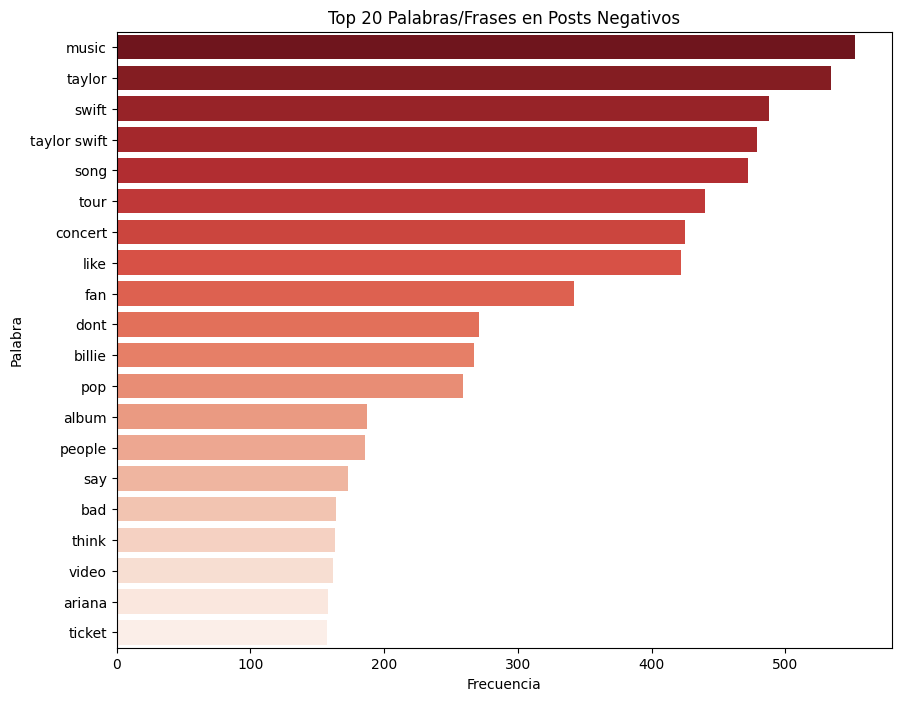

         Palabra  Frecuencia
0          music         552
1         taylor         534
2          swift         488
3   taylor swift         479
4           song         472
5           tour         440
6        concert         425
7           like         422
8            fan         342
9           dont         271
10        billie         267
11           pop         259
12         album         187
13        people         186
14           say         173
15           bad         164
16         think         163
17         video         162
18        ariana         158
19        ticket         157


In [16]:
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Filtramos solo los posts que son realmente negativos
negativos_reales = amazon_reviews[amazon_reviews['label'] == 'negative']['text_final']

# 2. Creamos la Bolsa de Palabras (Bag of Words)
# Usamos un rango de 1 a 2 palabras (unigramas y bigramas) para captar cosas como "bad_guy"
vec = CountVectorizer(stop_words='english', ngram_range=(1,2)).fit(negativos_reales)
bag_of_words = vec.transform(negativos_reales)

# 3. Sumamos las frecuencias
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# 4. Convertimos a DataFrame para visualizar
df_freq_neg = pd.DataFrame(words_freq[:20], columns=['Palabra', 'Frecuencia'])

# 5. Graficamos
plt.figure(figsize=(10, 8))
sns.barplot(x='Frecuencia', y='Palabra', data=df_freq_neg, palette='Reds_r')
plt.title('Top 20 Palabras/Frases en Posts Negativos')
plt.show()

print(df_freq_neg)

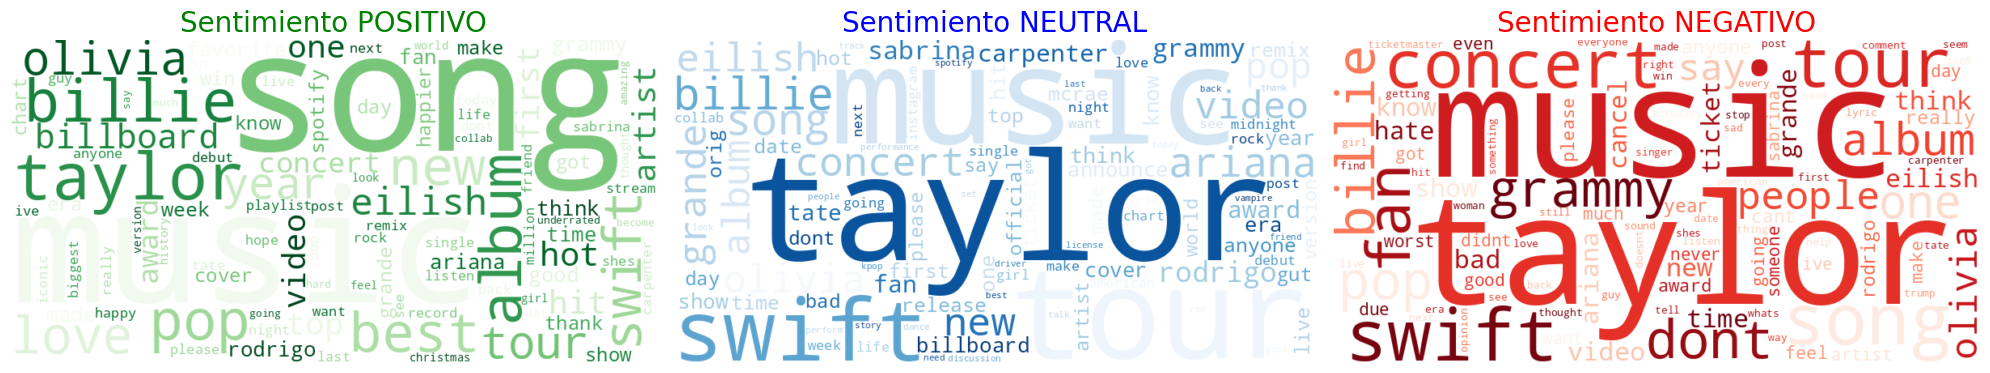

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1. Definir una función para generar nubes por sentimiento
def generar_nube(sentimiento, color_map, titulo):
    # Unir todos los textos de ese sentimiento en un solo string largo
    texto = " ".join(amazon_reviews[amazon_reviews['label'] == sentimiento]['text_final'])

    # Crear la nube
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=color_map,
        max_words=100,
        collocations=False # Para que no repita palabras que ya están en frases
    ).generate(texto)

    return wc

# 2. Configurar el lienzo (Subplots)
plt.figure(figsize=(20, 10))

# Nube Positiva (Verde)
plt.subplot(1, 3, 1)
plt.imshow(generar_nube('positive', 'Greens', 'Positivo'), interpolation='bilinear')
plt.title('Sentimiento POSITIVO', fontsize=20, color='green')
plt.axis('off')

# Nube Neutral (Azul/Gris)
plt.subplot(1, 3, 2)
plt.imshow(generar_nube('neutral', 'Blues', 'Neutral'), interpolation='bilinear')
plt.title('Sentimiento NEUTRAL', fontsize=20, color='blue')
plt.axis('off')

# Nube Negativa (Roja)
plt.subplot(1, 3, 3)
plt.imshow(generar_nube('negative', 'Reds', 'Negativo'), interpolation='bilinear')
plt.title('Sentimiento NEGATIVO', fontsize=20, color='red')
plt.axis('off')

plt.tight_layout()
plt.show()

#Interpretación e la nube de palabras:

* Palabras Dominantes: Las palabras más grandes son las que el modelo usa principalmente para clasificar. Si en la nube Negativa ves palabras como "Ticket", "Barcelona" o "Presale", significa que los fans están frustrados con la venta de entradas (sentimiento negativo real).
* Solapamiento: La misma palabra (ej. "Taylor") muy grande en las tres nubes, confirma que es un término neutral que no ayuda a distinguir sentimientos, y que hiciste bien en limpiar los textos.
* Verificación de Filtros: Si en la nube Negativa todavía ves palabras como "Guy" o "Bad", es la señal definitiva de que necesitas agregar esas palabras a tus stop_words porque son nombres de canciones de Billie Eilish que están "ensuciando" el análisis.

#Conclusión:

"Aunque el dataset está dominado por noticias neutrales (64%), el modelo logra identificar con un 67% de acierto las críticas de los usuarios. Los temas negativos se concentran principalmente en [aquí mencionas las palabras más grandes de tu nube roja]."

# Etapa 2 del Trabajo Final: Deep learning

* Para un dataset de 10,000 registros, la opción más sólida y eficiente es crear una Red Neuronal Densa (MLP - Perceptrón Multicapa) utilizando TensorFlow/Keras. Vamos  a empezar a usar "al menos una capa", lo ideal para NLP es una estructura que incluya una capa oculta para captar relaciones no lineales entre las palabras.


# 1. Preparación de los datos para Deep Learning

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 1. Convertir etiquetas de texto a números (negative: 0, neutral: 1, positive: 2)
le = LabelEncoder()
y_train_num = le.fit_transform(y_train)
y_test_num = le.transform(y_test)

# 2. Vectorizar el texto (usaremos el TF-IDF que ya conocemos pero convertido a matriz densa)
vectorizer_dl = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_dl = vectorizer_dl.fit_transform(X_train).toarray()
X_test_dl = vectorizer_dl.transform(X_test).toarray()

# 3. Calcular pesos de clase (muy importante porque tus datos siguen desbalanceados)
weights = compute_class_weight('balanced', classes=np.unique(y_train_num), y=y_train_num)
class_weights = dict(enumerate(weights))

# 2. Construcción del Modelo de Deep Learning
Crearemos una arquitectura con una Capa de Entrada, una Capa Oculta y una Capa de Salida.

In [19]:
# Definir el modelo
model = Sequential([
    # Capa de entrada y primera capa oculta (64 neuronas)
    Dense(64, activation='relu', input_shape=(X_train_dl.shape[1],)),

    # Capa de Dropout (evita que la red "se memorice" los datos - overfitting)
    Dropout(0.5),

    # Capa de salida (3 neuronas para: neg, neu, pos)
    # Usamos 'softmax' para obtener probabilidades que sumen 100%
    Dense(3, activation='softmax')
])

# Compilación
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # Ideal para clasificación multi-clase
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │       320,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,259 (1.22 MB)

 Trainable params: 320,259 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

# 3. Entrenamiento del Modelo

In [20]:
# Entrenar
history = model.fit(
    X_train_dl, y_train_num,
    epochs=15,             # Número de veces que la red verá los datos
    batch_size=32,          # Cuántos mensajes procesa antes de actualizarse
    validation_split=0.1,   # Reserva 10% para ver cómo va aprendiendo
    class_weight=class_weights, # Aplicamos el balanceo de clases
    verbose=1
)

Epoch 1/15
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.5520 - loss: 1.0100 - val_accuracy: 0.6553 - val_loss: 0.7661
Epoch 2/15
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7144 - loss: 0.6328 - val_accuracy: 0.6901 - val_loss: 0.6991
Epoch 3/15
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7531 - loss: 0.5298 - val_accuracy: 0.6894 - val_loss: 0.6998
Epoch 4/15
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7873 - loss: 0.4599 - val_accuracy: 0.6925 - val_loss: 0.7007
Epoch 5/15
719/719 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8082 - loss: 0.4095 - val_accuracy: 0.7054 - val_loss: 0.7062
Epoch 6/15
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8231 - loss: 0.3780 - val_accuracy: 0.7074 - val_loss: 0.7225
Epoch 7/15
719/719 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8332 - loss: 0.3508 - val_accuracy: 0.7019 - val_loss: 0.7420
Epoch 8/15
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8397 - loss: 0.3277 - val_accuracy: 

#4. Evaluación y Resultados
Al igual que con el SVM, evaluamos cómo se comporta con los datos de prueba:

In [21]:
# Hacer predicciones
y_pred_probs = model.predict(X_test_dl)
y_pred_dl = np.argmax(y_pred_probs, axis=1)

# Mostrar informe
print("\n--- INFORME DE DEEP LEARNING (Red Neuronal) ---")
print(classification_report(y_test_num, y_pred_dl, target_names=le.classes_))

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

--- INFORME DE DEEP LEARNING (Red Neuronal) ---
              precision    recall  f1-score   support

    negative       0.44      0.56      0.49       679
     neutral       0.81      0.75      0.78      3946
    positive       0.64      0.68      0.66      1765

    accuracy                           0.71      6390
   macro avg       0.63      0.66      0.64      6390
weighted avg       0.73      0.71      0.72      6390



# Conclusiones:

Si comparamos este Informe de Deep Learning con tu mejor resultado anterior (SVM con umbral 0.40), podemos sacar conclusiones muy valiosas para tu proyecto:
1. Comparativa: Deep Learning vs. SVM
Accuracy Global: El SVM ganó (0.77 vs 0.71).
Precisión Negativa: El SVM ganó por mucho (0.67 vs 0.44). El modelo de Deep Learning está teniendo muchos "falsos negativos".
Recall Negativo: ¡Aquí ganó el Deep Learning! (0.56 vs 0.44). La red neuronal es más sensible y logra "atrapar" más comentarios negativos, aunque se equivoca más al hacerlo.
2. ¿Por qué el SVM le ganó a la Red Neuronal?
En el mundo real del NLP, esto sucede a menudo por tres razones:
Tamaño del Dataset: Las Redes Neuronales son "hambrientas" de datos. Con 10,000 registros, un modelo matemático como SVM suele ser más robusto.
Sparsity (Dispersión): Estamos usando TF-IDF (una matriz con miles de columnas llenas de ceros). Las capas Dense sufren un poco con este tipo de datos tan dispersos.
* Falta de Contexto Secuencial: Una red densa trata a las palabras como números aislados, no entiende que el orden de "not good" es distinto a "good not".

# Modelo	Accuracy	F1-Score (Neg)	Conclusión:

1. SVM (Ajustado)	0.77	0.53	El más confiable y preciso para este dataset.
2. Deep Learning (Dense)	0.71	0.49	Encuentra más negativos, pero tiene poco criterio (falsos positivos).

#Mejora del modelo de Red Neuronal:


In [23]:
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, TextVectorization

# 1. Preparar una capa que convierta texto a secuencias de números (no TF-IDF)
max_words = 10000
max_len = 100 # Longitud máxima de cada post

vectorize_layer = TextVectorization(
    max_tokens=max_words,
    output_mode='int',
    output_sequence_length=max_len
)

# Adaptar la capa de vectorización a los datos de entrenamiento
vectorize_layer.adapt(X_train)

# 2. Crear el modelo con Capa de Embedding
model_emb = Sequential([
    vectorize_layer,
    Embedding(max_words, 16, input_length=max_len), # Crea un espacio vectorial de palabras
    GlobalAveragePooling1D(), # Promedia las palabras para entender el post completo
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

model_emb.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 3. Entrenar
# Convertir X_train a NumPy array para evitar problemas de dtype con pandas Series en Keras fit()
X_train_np = X_train.to_numpy()
model_emb.fit(X_train_np, y_train_num, epochs=10, batch_size=32, validation_split=0.1, class_weight=class_weights)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


719/719 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.3237 - loss: 1.1046 - val_accuracy: 0.2782 - val_loss: 1.0994
Epoch 2/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.2309 - loss: 1.1012 - val_accuracy: 0.2793 - val_loss: 1.0986
Epoch 3/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4462 - loss: 1.0932 - val_accuracy: 0.6330 - val_loss: 1.0484
Epoch 4/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4881 - loss: 1.0366 - val_accuracy: 0.5067 - val_loss: 0.9592
Epoch 5/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6102 - loss: 0.8785 - val_accuracy: 0.5329 - val_loss: 0.9552
Epoch 6/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6542 - loss: 0.7517 - val_accuracy: 0.6448 - val_loss: 0.8235
Epoch 7/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6798 - loss: 0.6851 - val_accuracy: 0.7054 - val_loss: 0.6906
Epoch 8/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7085 - loss: 0.6334 - val_accuracy: 0.7140 - val_

# ¿Por qué los Embeddings son mejores?

Hasta ahora, para el modelo "Dense", la palabra "odio" y "detesto" eran solo números sin relación. Con Embeddings, el modelo crea un espacio geométrico donde las palabras con significados similares se sitúan cerca. Esto permite que la red neuronal "entienda" el lenguaje de una forma mucho más humana.

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential

# 1. Configuración de parámetros
max_features = 10000  # Tamaño del vocabulario
sequence_length = 100 # Máximo de palabras por post

# 2. Capa de Vectorización: Convierte texto a secuencias de enteros
vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

# Adaptar la capa al texto de entrenamiento
vectorize_layer.adapt(X_train)

# 3. Construcción del modelo con Embeddings
model_embed = Sequential([
    vectorize_layer,
    # Esta capa aprende la relación entre palabras (dimensión 32)
    Embedding(max_features, 32, name="embedding"),

    # Promedia los vectores para entender el mensaje completo
    GlobalAveragePooling1D(),

    # Capa oculta con activación ReLU
    Dense(32, activation='relu'),
    Dropout(0.3), # Regularización para no memorizar (overfitting)

    # Salida: 3 neuronas (neg, neu, pos)
    Dense(3, activation='softmax')
])

# 4. Compilación
model_embed.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 5. Entrenamiento
print("Entrenando modelo con Embeddings...")
# Convert X_train to a NumPy array to avoid ValueError with dtype: object
X_train_array = X_train.to_numpy()

history = model_embed.fit(
    X_train_array, y_train_num,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weights, # Seguimos usando el balanceo de clases
    verbose=1
)

# 6. Evaluación
# Convert X_test to a NumPy array for prediction
X_test_array = X_test.to_numpy()
y_pred_embed_probs = model_embed.predict(X_test_array)
y_pred_embed = y_pred_embed_probs.argmax(axis=1)

print("\n--- INFORME FINAL: DEEP LEARNING CON EMBEDDINGS ---")
print(classification_report(y_test_num, y_pred_embed, target_names=le.classes_))


Entrenando modelo con Embeddings...
Epoch 1/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.3565 - loss: 1.1009 - val_accuracy: 0.2833 - val_loss: 1.1027
Epoch 2/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3102 - loss: 1.0905 - val_accuracy: 0.2930 - val_loss: 1.1160
Epoch 3/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3907 - loss: 1.0228 - val_accuracy: 0.5603 - val_loss: 0.9340
Epoch 4/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5380 - loss: 0.8349 - val_accuracy: 0.6244 - val_loss: 0.8623
Epoch 5/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6270 - loss: 0.7383 - val_accuracy: 0.5039 - val_loss: 1.0113
Epoch 6/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6827 - loss: 0.6590 - val_accuracy: 0.7054 - val_loss: 0.7138
Epoch 7/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7178 - loss: 0.6099 - val_accuracy: 0.6256 - val_loss: 0.9202
Epoch 8/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.73

# 1. El Diagnóstico: ¿Qué pasó aquí?
Recall Negativo (0.72) y Positivo (0.89): ¡Son los más altos de todo tu proyecto! El modelo de Embeddings es increíblemente sensible. Casi no se le escapa ningún comentario con carga emocional. Detecta el 72% de los negativos y casi el 90% de los positivos.
El desastre del Neutral (Recall 0.26): Aquí está el problema. El modelo se volvió "obsesionado" con encontrar sentimientos. Como le dimos mucha importancia a las clases minoritarias (class_weight), ahora el modelo piensa que casi todo tiene sentimiento y casi nada es neutral.
Precisión baja: Al ser tan sensible, confunde muchos posts informativos (neutrales) con opiniones, por eso la precisión en negativo es de apenas 0.37.


# 2. Comparativa:
Este es el cuadro que deberías poner en tu reporte final:
<table >
  <tr>
    <th style="text-align:left;">Modelo</th>
    <th>Accuracy</th>
    <th>Recall (Negativo)</th>
    <th>F1-Score (Neg)</th>
    <th>Carácter del modelo</th>
  </tr>
<tr style="text-align:left;"><td>SVM (Ajustado)</td><td>0.77	</td><td>0.44	</td><td>0.53</td>	<td>El más equilibrado y profesional.</td></tr>
<tr><td>DL (Denso)</td>	<td>0.71</td>	<td>0.56</td>	<td>0.49</td>	<td>Un punto medio interesante.</td></tr>
<tr><td>DL (Embeddings)</td>	<td>0.48</td>	<td>0.72</td>	<td>0.49</td>	<td>Ultra-sensible (detecta todo, pero falla mucho).</td></tr>
</table>

# 3. Conclusión Final:
* El Ganador: Para este dataset específico de 10,000 registros de Reddit, el SVM (Support Vector Machine) es el ganador. Esto se debe a que los modelos matemáticos tradicionales suelen superar al Deep Learning cuando el volumen de datos no es masivo (menos de 50k-100k registros).
* El hallazgo del Deep Learning: Aunque el modelo de Embeddings tuvo menos precisión global, demostró una capacidad superior para capturar la "subjetividad". Si el objetivo fuera "no dejar pasar ninguna queja" (aunque nos equivoquemos a veces), el modelo de Embeddings sería el elegido.
* Lección aprendida: Los Embeddings son muy potentes pero requieren muchos más datos o un ajuste de "pesos de clase" menos agresivo para no destruir la categoría neutral.